Original image shape: (256, 256, 3)
Expanded input shape for ONNX: (1, 256, 256, 3)
Model expects input shape: ['unk__614', 256, 256, 3]
Raw model output shape: (256, 256, 7)

Predicted Area Coverage:
---------------------------
✅ urban_land: 0.04%
✅ agriculture_land: 13.16%
✅ rangeland: 1.29%
✅ water: 6.86%
✅ barren_land: 7.46%
✅ unknown: 71.20%


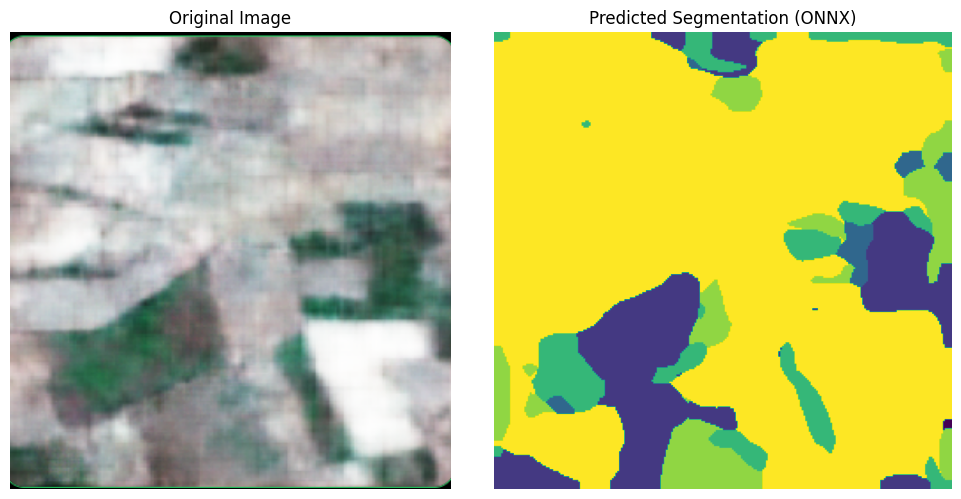

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
from PIL import Image
import os

# 1. Define paths and model parameters
ONNX_MODEL_PATH = r"C:\Users\amanr\Desktop\satellite-colorizer\segmentation_model.onnx"
IMG_SIZE = (256, 256)  # Model input size

# 2. Class mapping (7 classes)
class_to_name = {
    0: "urban_land",
    1: "agriculture_land",
    2: "rangeland",
    3: "forest_land",
    4: "water",
    5: "barren_land",
    6: "unknown"
}

# 3. Load and preprocess image
def load_image(image_path):
    """Load and preprocess an image for ONNX model (HWC → NHWC)."""
    try:
        img = Image.open(image_path).convert('RGB').resize(IMG_SIZE)  # <--- Force RGB
        img_array = np.array(img).astype(np.float32) / 255.0  # Normalize
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        return None


# 4. Predict segmentation using ONNX model
def predict_segmentation(image_path, onnx_model_path):
    if not os.path.exists(onnx_model_path):
        print(f"Error: ONNX model not found at {onnx_model_path}")
        return None

    img = load_image(image_path)
    if img is None:
        return None

    print(f"Original image shape: {img.shape}")  # Should be (256, 256, 3)

    # Model expects NHWC format
    img_exp = np.expand_dims(img, axis=0)  # Shape: (1, H, W, C)

    print(f"Expanded input shape for ONNX: {img_exp.shape}")

    ort_session = ort.InferenceSession(onnx_model_path)
    input_name = ort_session.get_inputs()[0].name
    input_shape = ort_session.get_inputs()[0].shape
    print(f"Model expects input shape: {input_shape}")

    # Run inference
    ort_inputs = {input_name: img_exp}
    ort_outputs = ort_session.run(None, ort_inputs)

    # Get output and convert to class predictions
    pred_mask = ort_outputs[0][0]  # Shape: (H, W, num_classes)

    print(f"Raw model output shape: {pred_mask.shape}")

    if pred_mask.ndim == 3:
        pred_mask = np.argmax(pred_mask, axis=-1)  # Shape: (H, W)
    else:
        print("Unexpected output shape from model.")
        return None

    # Area coverage calculation
    total_pixels = pred_mask.size
    unique_classes, counts = np.unique(pred_mask, return_counts=True)

    print("\nPredicted Area Coverage:")
    print("---------------------------")
    for class_id, count in zip(unique_classes, counts):
        percentage = (count / total_pixels) * 100
        class_name = class_to_name.get(class_id, f"Class {class_id}")
        print(f"✅ {class_name}: {percentage:.2f}%")

    return pred_mask

# 5. Main execution
if __name__ == "__main__":
    try:
        test_image_path = r"C:\Users\amanr\Desktop\satellite-colorizer\image.png"
        predicted_mask = predict_segmentation(test_image_path, ONNX_MODEL_PATH)

        if predicted_mask is not None:
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(Image.open(test_image_path))
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(predicted_mask, cmap="viridis")
            plt.title("Predicted Segmentation (ONNX)")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error: {str(e)}")
        print("\nTroubleshooting tips:")
        print("1. Ensure onnxruntime is installed: pip install onnxruntime")
        print("2. Check if the ONNX model path is correct")
